In [184]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# BDT packages
import xgboost as xgb
import lightgbm as lgb

### Set default plot parameters
# Font and fontsize
rc = {"font.family" : "serif", 
      "mathtext.fontset" : "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12

# Grid
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['grid.color'] = 'white'
plt.rcParams['axes.grid'] = True

# Background color
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'gainsboro'
plt.rcParams['savefig.facecolor'] = 'white'

# Legend background color
plt.rcParams['legend.facecolor'] = 'white'

In [185]:
# Loading the data
data = pd.read_csv("SDSS-Gaia_5950stars.csv", index_col=0)



# Determining the 7 most important features for clustering
___

### PCA importance analysis

In [186]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X_scaled = StandardScaler().fit_transform(data)

pca = PCA(n_components=5)
X_pca = pca.fit(X_scaled)

# Importance of features
pca_importance = np.abs(X_pca.components_).sum(axis=0)
sorted_idx = np.argsort(pca_importance)[::-1]
pca_top7_featues = data.columns[sorted_idx][:7].tolist()
print("Top 7 features: ", pca_top7_featues)


Top 7 features:  ['Lz', 'Energy', 'K', 'H', 'N_FE', 'J', 'C_FE']


### Laplacian Score feature analysis

In [187]:
from skfeature.utility import construct_W
from skfeature.function.similarity_based import lap_score
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(data)

kwargs_W = {"neighbor_mode": "knn", "k": 5}
W = construct_W.construct_W(X_scaled, **kwargs_W)

lap_score_value = lap_score.lap_score(X_scaled, W=W)
feature_indices = np.argsort(lap_score_value)
top7_idx = feature_indices[:7]

lap_top7_features = data.columns[top7_idx].tolist()
print("Top 7 features by Laplacian Score:", lap_top7_features)

lap_top7_features_series = pd.Series(lap_top7_features)
lap_top7_features_series.to_csv("handins/Clustering_NielsDavidsen_KmeansOnT-SNE_VariableList.csv", index=False, header=False)
lap_top7_features_series.to_csv("handins/Clustering_NielsDavidsen_SpectralClusteringOnUMAP_VariableList.csv", index=False, header=False)


Top 7 features by Laplacian Score: ['Energy', 'E', 'K', 'Lz', 'FE_H', 'O_FE', 'CA_FE']


___
# Clustering of Gaia data

/Users/nielsaugustdavidsen/Documents/GitHub/AppliedML2025_fork/appmlenv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nielsaugustdavidsen/Documents/GitHub/AppliedML2025_fork/appmlenv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/nielsaugustdavidsen/Documents/GitHub/AppliedML2025_fork/appmlenv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/nielsaugustdavidsen/Documents/GitHub/AppliedML2025_fork/appmlenv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/nielsaugustdavidsen/Documents/GitHub/AppliedML2025_fork/appmlenv/lib/python3.12/site-packages/sklearn/utils/extmath.py:2

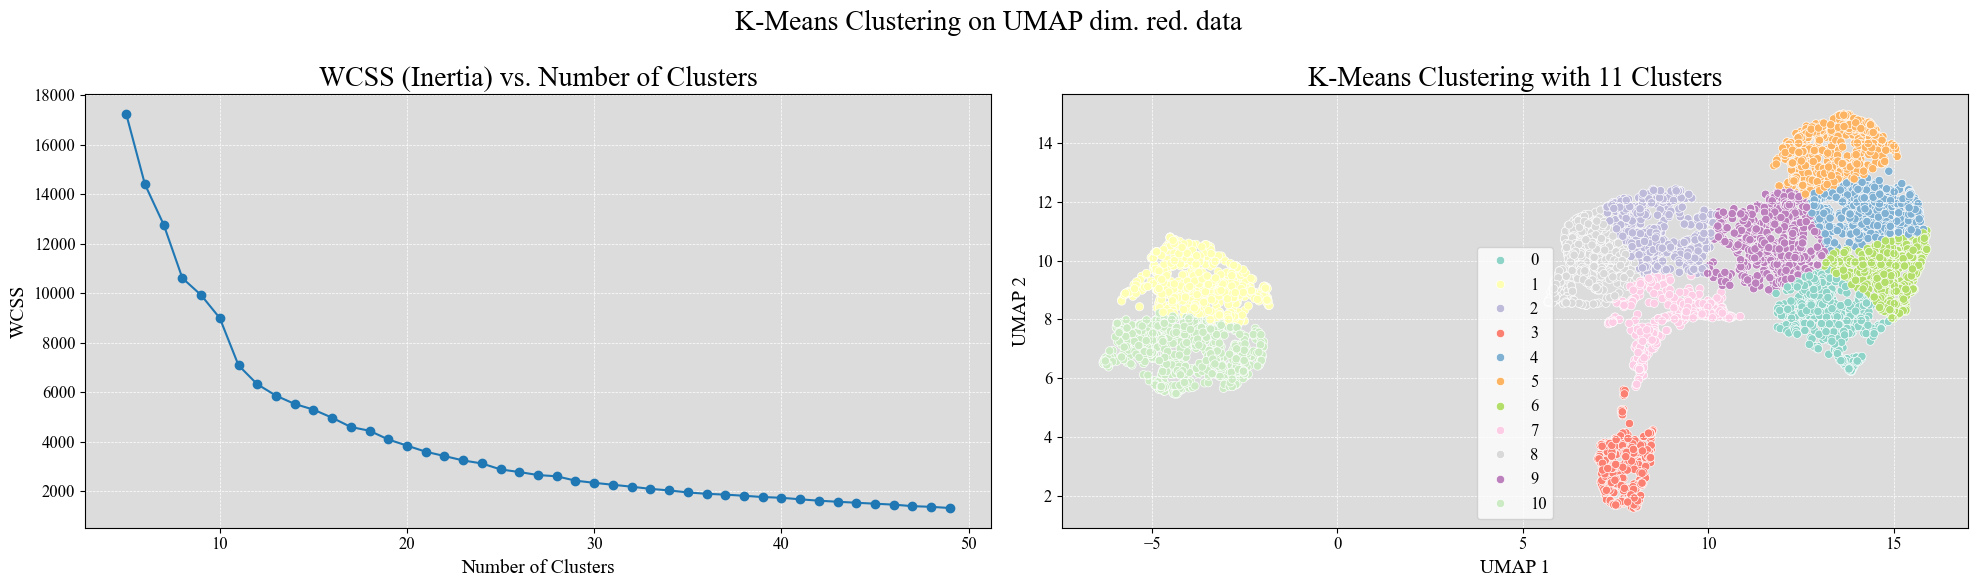

In [122]:
# K-Means Clustering
from sklearn.cluster import KMeans
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import silhouette_score
from umap import UMAP

# WCSS elbot method


# Use the top 7 features from Laplacian Score
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data[lap_top7_features])
# X_scaled = scaler.fit_transform(data[pca_top7_featues])

# UMAP dimensionality reduction
umap_model = UMAP(n_neighbors=10, min_dist=0.1, metric='euclidean', random_state=42, n_components=2)
X_umap = umap_model.fit_transform(X_scaled)

# K-means clustering on UMAP output
n_clusters = range(5, 50)
wcss = []
for n in n_clusters:
    kmeans = KMeans(n_clusters=n, random_state=42)
    labels = kmeans.fit_predict(X_umap)
    
    # Calculate WCSS (inertia)
    score = kmeans.inertia_
    wcss.append(score)



# Ploting the silhouette scores
fig, ax = plt.subplots(1,2,figsize=(20, 6))
ax[0].plot(n_clusters, wcss, marker='o')
ax[0].set_title('WCSS (Inertia) vs. Number of Clusters')
ax[0].set_xlabel('Number of Clusters')
ax[0].set_ylabel('WCSS')


# Choosing the optimal number of clusters
optimal_n = 11
kmeans = KMeans(n_clusters=optimal_n, random_state=42)
labels = kmeans.fit_predict(X_umap)

# Plot the UMAP output with cluster labels
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=labels, palette='Set3', ax=ax[1])
ax[1].set_title(f'K-Means Clustering with {optimal_n} Clusters')
ax[1].set_xlabel('UMAP 1')
ax[1].set_ylabel('UMAP 2')




plt.suptitle('K-Means Clustering on UMAP dim. red. data', fontsize=20)
plt.tight_layout()


Number of clusters: 9
Number of noise points: 1084
Total # of points: 5950


/Users/nielsaugustdavidsen/Documents/GitHub/AppliedML2025_fork/appmlenv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nielsaugustdavidsen/Documents/GitHub/AppliedML2025_fork/appmlenv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


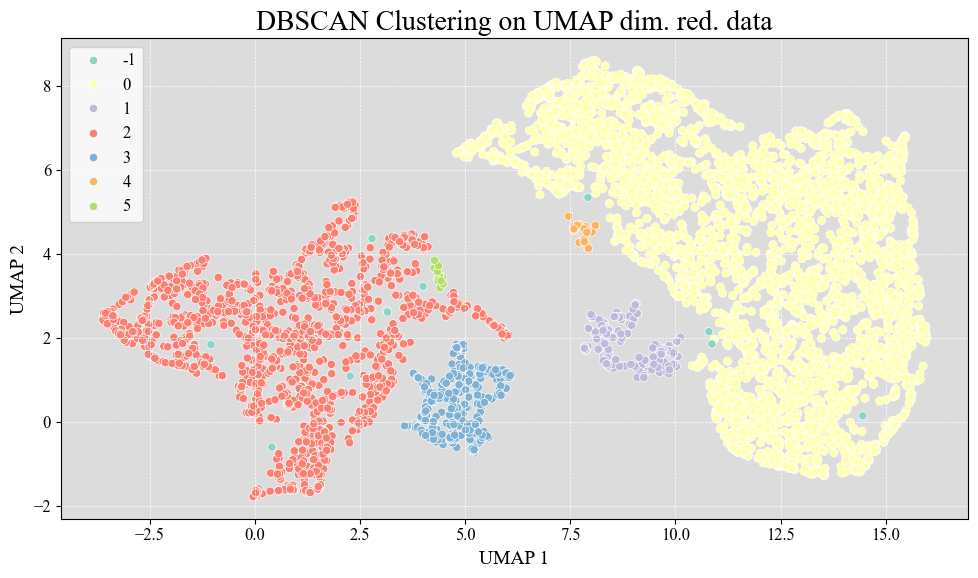

In [138]:
# DBSCAN Clustering
from sklearn.cluster import DBSCAN

# First without dimensionality reduction
#X_scaled = scaler.fit_transform(data[lap_top7_features])
X_scaled = scaler.fit_transform(data[pca_top7_featues])

# DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
labels = dbscan.fit_predict(X_scaled)

# Print the number of clusters and noise points
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)
print(f"Number of clusters: {n_clusters}")
print(f"Number of noise points: {n_noise}")
print(f"Total # of points: {len(labels)}")


### Then with UMAP ###

# UMAP dimensionality reduction
umap_model = UMAP(n_neighbors=10, min_dist=0.1, metric='euclidean', random_state=42, n_components=2)
X_umap = umap_model.fit_transform(X_scaled)

# DBSCAN clustering on UMAP output
dbscan = DBSCAN(eps=0.3, min_samples=5)
labels = dbscan.fit_predict(X_umap)

# Plot the UMAP output with cluster labels
fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=labels, palette='Set3', ax=ax)
ax.set_title('DBSCAN Clustering on UMAP dim. red. data')
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
plt.tight_layout()

/Users/nielsaugustdavidsen/Documents/GitHub/AppliedML2025_fork/appmlenv/lib/python3.12/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/nielsaugustdavidsen/Documents/GitHub/AppliedML2025_fork/appmlenv/lib/python3.12/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/nielsaugustdavidsen/Documents/GitHub/AppliedML2025_fork/appmlenv/lib/python3.12/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/nielsaugustdavidsen/Documents/GitHub/AppliedML2025_fork/appmlenv/lib/python3.12/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/nielsaugustdavidsen/Documents/GitHub/AppliedML2025_fork/appmlenv/lib/python3.12/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: overflow encou

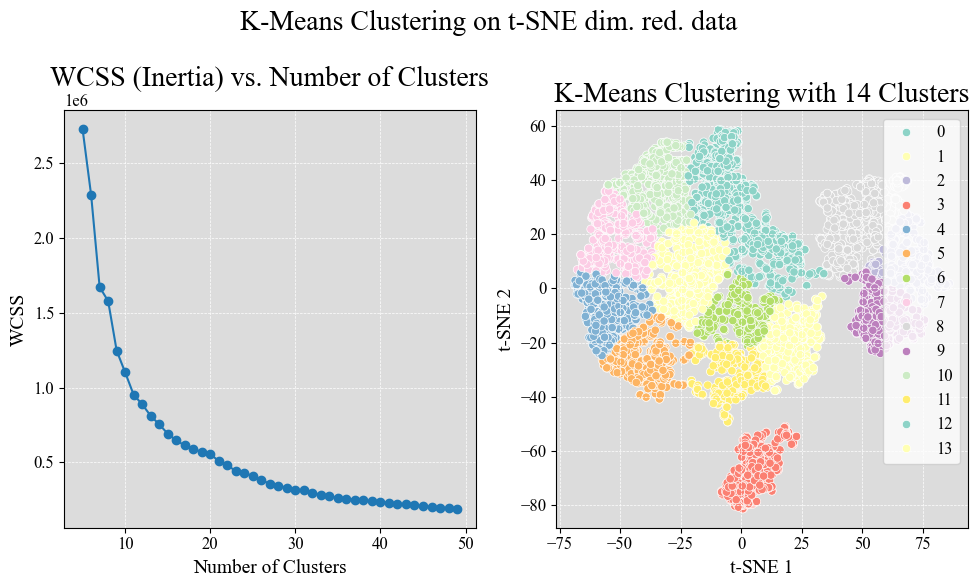

In [174]:
# t-SNE dimensionality reduction
from sklearn.manifold import TSNE

# X_scaled = scaler.fit_transform(data[lap_top7_features])
vari_data = data[lap_top7_features]
X_scaled = scaler.fit_transform(vari_data)

tsne_model = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne_model.fit_transform(X_scaled)

# Elbow method for t-SNE
n_clusters = range(5, 50)
wcss = []

for n in n_clusters:
    kmeans = KMeans(n_clusters=n, random_state=42)
    labels = kmeans.fit_predict(X_tsne)
    
    # Calculate WCSS (inertia)
    score = kmeans.inertia_
    wcss.append(score)

# Plotting the WCSS
fig, ax = plt.subplots(1,2, figsize=(10, 6))
ax[0].plot(n_clusters, wcss, marker='o')
ax[0].set_title('WCSS (Inertia) vs. Number of Clusters')
ax[0].set_xlabel('Number of Clusters')
ax[0].set_ylabel('WCSS')
# Choosing the optimal number of clusters
optimal_n = 14

kmeans = KMeans(n_clusters=optimal_n, random_state=42)
labels = kmeans.fit_predict(X_tsne)

# Plot the t-SNE output with cluster labels
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=labels, palette='Set3', ax=ax[1])
ax[1].set_title(f'K-Means Clustering with {optimal_n} Clusters')
ax[1].set_xlabel('t-SNE 1')
ax[1].set_ylabel('t-SNE 2')
plt.suptitle('K-Means Clustering on t-SNE dim. red. data', fontsize=20)
plt.tight_layout()


In [ ]:
# Save labels in a CSV file
labels_df = pd.Series(labels)
labels_df.to_csv("handins/Clustering_NielsDavidsen_KmeansOnT-SNE.csv", index=True, header=False)

/Users/nielsaugustdavidsen/Documents/GitHub/AppliedML2025_fork/appmlenv/lib/python3.12/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/nielsaugustdavidsen/Documents/GitHub/AppliedML2025_fork/appmlenv/lib/python3.12/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/nielsaugustdavidsen/Documents/GitHub/AppliedML2025_fork/appmlenv/lib/python3.12/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/nielsaugustdavidsen/Documents/GitHub/AppliedML2025_fork/appmlenv/lib/python3.12/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/nielsaugustdavidsen/Documents/GitHub/AppliedML2025_fork/appmlenv/lib/python3.12/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: overflow encou

Number of clusters: 10
Number of noise points: 5838
Total # of points: 5950


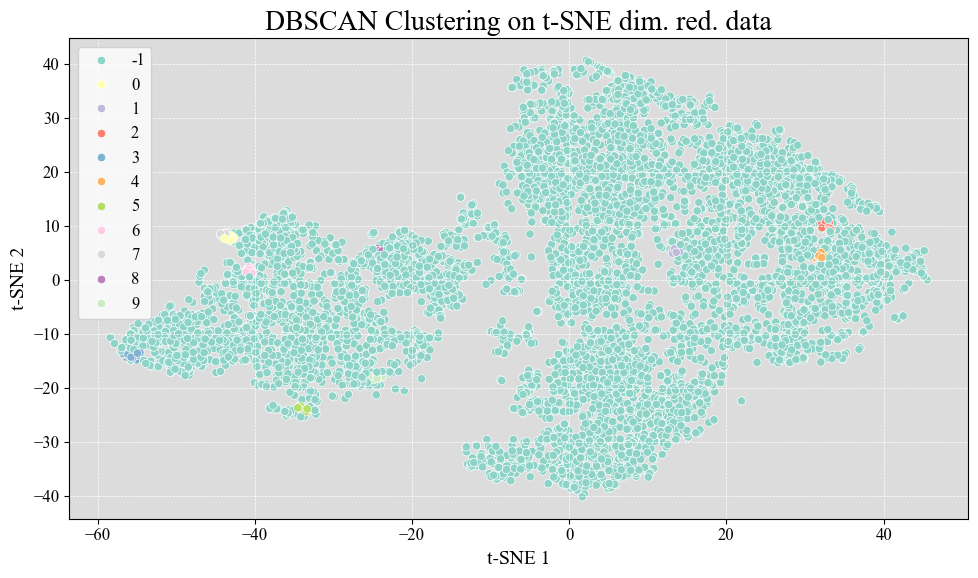

In [ ]:
# DBSCAN Clustering on t-SNE output

# t-SNE dimensionality reduction
# X_scaled = scaler.fit_transform(data[lap_top7_features])
X_scaled = scaler.fit_transform(data[pca_top7_featues])

tsne_model = TSNE(n_components=2, perplexity=100, random_state=42)
X_tsne = tsne_model.fit_transform(X_scaled)

# DBSCAN clustering on t-SNE output
dbscan = DBSCAN(eps=0.7, min_samples=10)
labels = dbscan.fit_predict(X_tsne)
# Print the number of clusters and noise points
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)
print(f"Number of clusters: {n_clusters}")
print(f"Number of noise points: {n_noise}")
print(f"Total # of points: {len(labels)}")

# Plot the t-SNE output with cluster labels
fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=labels, palette='Set3', ax=ax)
ax.set_title('DBSCAN Clustering on t-SNE dim. red. data')
ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
plt.tight_layout()



/Users/nielsaugustdavidsen/Documents/GitHub/AppliedML2025_fork/appmlenv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nielsaugustdavidsen/Documents/GitHub/AppliedML2025_fork/appmlenv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/nielsaugustdavidsen/Documents/GitHub/AppliedML2025_fork/appmlenv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/nielsaugustdavidsen/Documents/GitHub/AppliedML2025_fork/appmlenv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/nielsaugustdavidsen/Documents/GitHub/AppliedML2025_fork/appml

Optimal number of clusters: 14


/Users/nielsaugustdavidsen/Documents/GitHub/AppliedML2025_fork/appmlenv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/nielsaugustdavidsen/Documents/GitHub/AppliedML2025_fork/appmlenv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/nielsaugustdavidsen/Documents/GitHub/AppliedML2025_fork/appmlenv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/nielsaugustdavidsen/Documents/GitHub/AppliedML2025_fork/appmlenv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/nielsaugustdavidsen/Documents/GitHub/AppliedML2025_fork/appmlenv/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zer

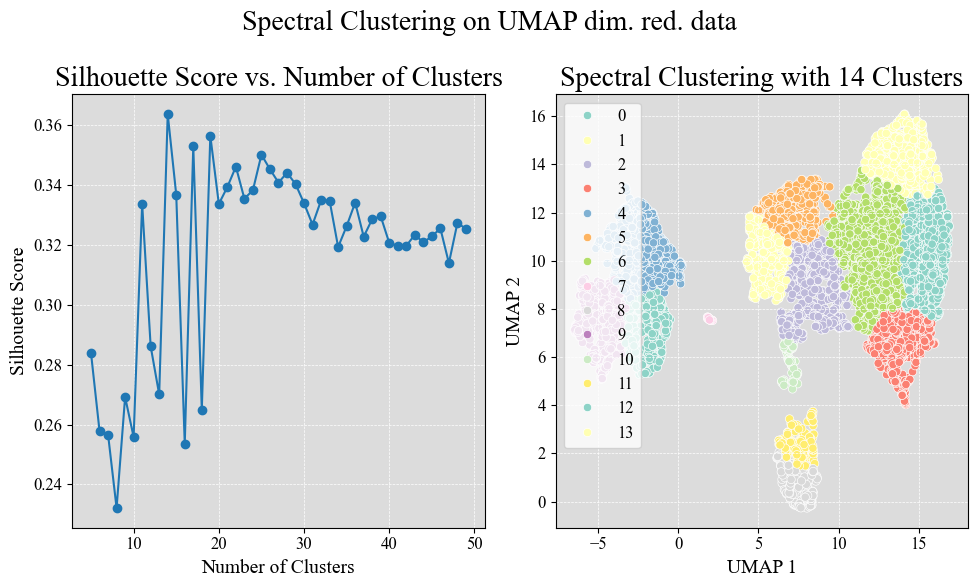

In [178]:
# Spectral Clustering
from sklearn.cluster import SpectralClustering

X_scaled = scaler.fit_transform(data[lap_top7_features])
# X_scaled = scaler.fit_transform(data[pca_top7_featues])

# UMAP dimensionality reduction
umap_model = UMAP(n_neighbors=5, min_dist=0.2, metric='euclidean', random_state=42, n_components=2)
X_umap = umap_model.fit_transform(X_scaled)

# Spectral clustering
n_range = range(5, 50)
sil_score = []
for n in n_range:
    spectral = SpectralClustering(n_clusters=n, affinity='nearest_neighbors', random_state=42)
    labels = spectral.fit_predict(X_umap)

    # Calculate silhouette score
    score = silhouette_score(X_umap, labels)
    sil_score.append(score)

fig, ax = plt.subplots(1,2, figsize=(10, 6))
# Plotting the silhouette scores
ax[0].plot(n_range, sil_score, marker='o')
ax[0].set_title('Silhouette Score vs. Number of Clusters')
ax[0].set_xlabel('Number of Clusters')
ax[0].set_ylabel('Silhouette Score')

# Choosing the optimal number of clusters
n_clusters = np.argmax(sil_score) + 5
print(f"Optimal number of clusters: {n_clusters}")

spectral = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=42)
labels = spectral.fit_predict(X_umap)

# Plot the UMAP output with cluster labels
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=labels, palette='Set3', ax=ax[1])
ax[1].set_title(f'Spectral Clustering with {n_clusters} Clusters')
ax[1].set_xlabel('UMAP 1')
ax[1].set_ylabel('UMAP 2')
plt.suptitle('Spectral Clustering on UMAP dim. red. data', fontsize=20)
plt.tight_layout()


In [179]:
 # Save the labels in a CSV file
labels_df = pd.Series(labels)
labels_df.to_csv("handins/Clustering_NielsDavidsen_SpectralClusteringOnUMAP.csv", index=True, header=False)